In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import csv
import cartopy.crs as ccrs

In [47]:
bus_csv = '../data/RTS-GMLC/SourceData/bus.csv'
branch_csv = '../data/RTS-GMLC/SourceData/branch.csv'
gen_csv = '../data/RTS-GMLC/SourceData/on_gen.csv'
pmaps_scenario = '../../data/scenario_data/RTS_GMLC_1.json'

buses = csv.DictReader(open(bus_csv))
bus_data = []
for bus in buses:
    bus_data.append((int(bus['Bus ID']), float(bus['lat']), float(bus['lng'])))

lines = csv.DictReader(open(branch_csv))
line_data = {}
line_counter = 1
for line in lines: 
    line_data[line_counter] = (int(line['From Bus']), int(line['To Bus']))
    line_counter += 1
    
gens = csv.DictReader(open(gen_csv))
gen_data = {} 
for gen in gens: 
    id = int(gen['Gen ID'])
    bus_id = int(gen['Bus ID'])
    gen_data[id] = bus_id
    
scenario_data = {}
gens_in_cluster = set()
lines_in_cluster = set()
with open(pmaps_scenario, 'r') as file:
    # Load the JSON data
    data = json.load(file)
    for (id, scenario) in data.items():
        scenario_data[int(id)] = {} 
        scenario_data[int(id)]['gen'] = scenario['gen']
        gens_in_cluster.update(scenario['gen'])
        scenario_data[int(id)]['line'] = scenario['branch']
        lines_in_cluster.update(scenario['branch'])

buses_in_cluster = set(map(lambda x: gen_data[x], gens_in_cluster))
print(buses_in_cluster)
print(lines_in_cluster)

{201, 202, 107, 207, 213, 214, 215, 216, 218, 221, 222, 223}
{12, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79}


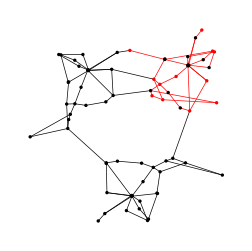

In [101]:
# Create an empty graph
fig, ax = plt.subplots()

G = nx.Graph()

import matplotlib
matplotlib.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size' : 12,
    'pgf.rcfonts': False,
})

for (i, x, y) in bus_data: 
    G.add_node(i, pos=(x, y))
pos = nx.get_node_attributes(G, 'pos')
node_color_map = []
for node in G:
    if node in buses_in_cluster:
        node_color_map.append('red')
    else: 
        node_color_map.append('black')      

for (id, val) in line_data.items():
    if id in lines_in_cluster:
        G.add_edge(val[0], val[1], edge_color='red')
    else: 
        G.add_edge(val[0], val[1], edge_color='black')

edges = G.edges()
colors = [G[u][v]['edge_color'] for (u, v) in edges]


fig.set_size_inches(3, 3)
nx.draw(G, pos=pos, node_color=node_color_map, 
        edge_color=colors, node_size=2, width=0.5)

plt.savefig('../plots/RTS-GMLC-scenarios.pdf')

In [10]:
with open('../tables/num_scenario_times.csv', 'w', newline='') as csvfile:
    fieldnames = ['k', 's50', 's100', 's150', 's200']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for k in range(1, 11): 
        row = {'k' : k} 
        for s in range(50, 201, 50): 
            result = {} 
            file = '../../output/stochastic/RTS-GMLC--sto--RTS-GMLC-1--k{}--m{}.json'.format(k, s)
            with open(file, 'r') as jsonfile:
                data = json.load(jsonfile)
                result = data['results'] 
            row['s{}'.format(s)] = round(result['run_time'])
        writer.writerow(row)

with open('../tables/VSS.csv', 'w', newline='') as csvfile: 
    fieldnames = ['k', 'RS', 'EEV', 'VSS', 'VSS_percent']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader() 
    
    eev_file = '../data/EEV.json'
    eev_values = {} 
    with open(eev_file, 'r') as jsonfile: 
        eev_values = json.load(jsonfile)

    for k in range(1, 11): 
        row = {'k' : k} 
        result = {} 
        file = '../../output/stochastic/RTS-GMLC--sto--RTS-GMLC-1--k{}--m200.json'.format(k)
        with open(file, 'r') as jsonfile:
            data = json.load(jsonfile)
            result = data['results'] 
        row['RS'] = round(result['objective'], 2)
        row['EEV'] = round(eev_values[str(k)], 2)
        row['VSS'] = round(row['RS'] -row['EEV'], 2) # maximization problem
        rel = (row['RS'] -row['EEV'])/row['RS'] * 100.0
        row['VSS_percent'] = round(rel, 2)
        writer.writerow(row)
        

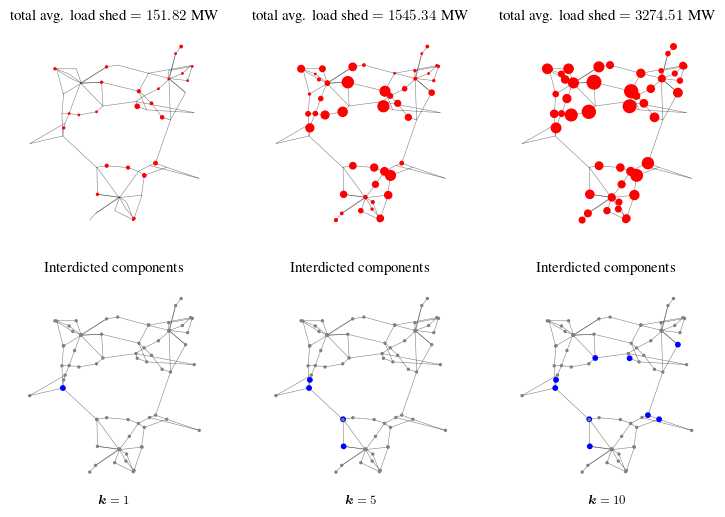

In [206]:
# Create an empty graph
import matplotlib
matplotlib.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size' : 9,
    'pgf.rcfonts': False,
})

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}\usepackage{times}'

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(9, 6)

kvals = [1, 5, 10]

ratio = {}

with open('../data/expected_ls_factor.json', 'r') as file:
    ratio = json.load(file)

ub = 100.0
lb = 0.0
for idx, k in enumerate(kvals): 
    bus_ratio = ratio[str(k)]
    result = {} 
    file = '../../output/stochastic/RTS-GMLC--sto--RTS-GMLC-1--k{}--m200.json'.format(k)
    with open(file, 'r') as jsonfile:
        result = json.load(jsonfile)['results']
    objective = round(result['objective'], 2)
    lines = result['lines']
    gens = result['generators']
    buses = list(set(map(lambda x: gen_data[x], gens)))
    G = nx.Graph()
    
    node_size = []
    for (i, x, y) in bus_data: 
        l = bus_ratio[str(i)]
        s = lb * (1 - l) + l * ub
        G.add_node(i, pos = (x, y), size = round(s))
        node_size.append(round(s))
    pos = nx.get_node_attributes(G, 'pos')
    # node_size = nx.get_node_attributes(G, 'size')

        
    for (id, val) in line_data.items():
        if id in lines_in_cluster:
            G.add_edge(val[0], val[1])
        else: 
            G.add_edge(val[0], val[1])

    nx.draw_networkx_edges(G, pos=pos, ax=ax[0, idx], width=0.4, alpha=0.5)
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, 
                           ax=ax[0, idx], 
                           node_color='red')
    ax[0, idx].axis('off')
    ax[0, idx].set_title(r'total avg. load shed $={}$ MW'.format(objective))
    
    # second graph
    G = nx.Graph()
    
    node_size = []
    for (i, x, y) in bus_data: 
        G.add_node(i, pos=(x, y))
        if i in buses: 
            node_size.append(10.0)
        else:
            node_size.append(2.0)
    pos = nx.get_node_attributes(G, 'pos')
    node_color_map = []
    for node in G:
        if node in buses:
            node_color_map.append('blue')
        else: 
            node_color_map.append('gray')      

    for (id, val) in line_data.items():
        if id in lines:
            G.add_edge(val[0], val[1], edge_color='blue')
        else: 
            G.add_edge(val[0], val[1], edge_color='black')

    edges = G.edges()
    colors = [G[u][v]['edge_color'] for (u, v) in edges]    

    nx.draw_networkx_edges(G, pos=pos, ax=ax[1, idx], width=0.4, alpha=0.5)
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size,
                           ax=ax[1, idx], 
                           node_color=node_color_map)
    # ax[1, idx].axis('off')
    ax[1, idx].set_title(r'Interdicted components')
    ax[1, idx].set_xlabel(r'$\bm k={}$'.format(k))
    ax[1, idx].spines['bottom'].set_color('white')
    ax[1, idx].spines['top'].set_color('white')
    ax[1, idx].spines['right'].set_color('white')
    ax[1, idx].spines['left'].set_color('white')

# plt.suptitle(r'Optimal interdiction plans and load sheds')
plt.savefig('../plots/RTS-GMLC-solutions.pdf')
plt.show()
